In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
from scipy.ndimage import convolve
from tools import *
import sys
from compute_sifts import *
del sys.modules["compute_sifts"]
#del compute_sifts
from compute_sifts import *

# Partie 1 : SIFT

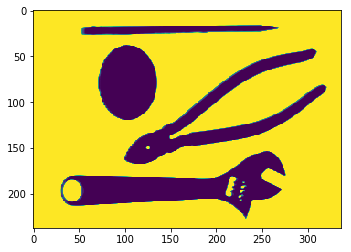

In [2]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

In [3]:
# example d'affichage du résultat
compute_grad_mod_ori(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

NameError: name 'Ix' is not defined

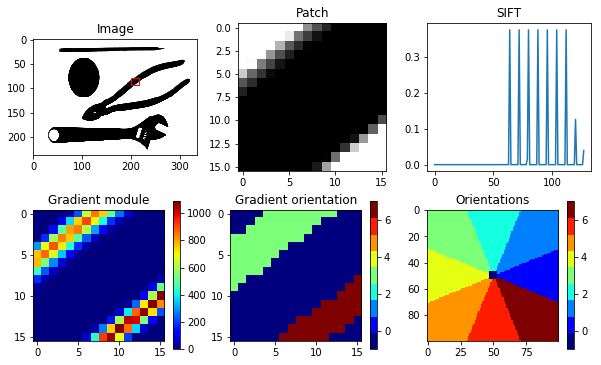

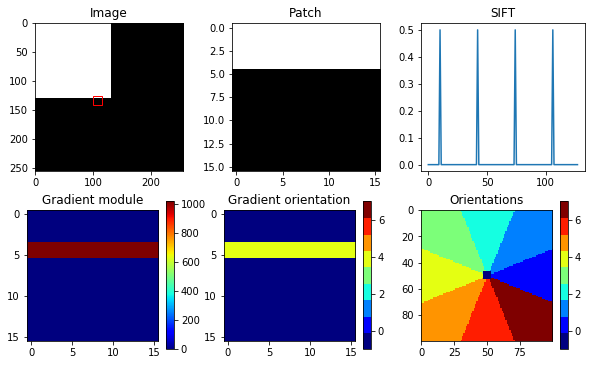

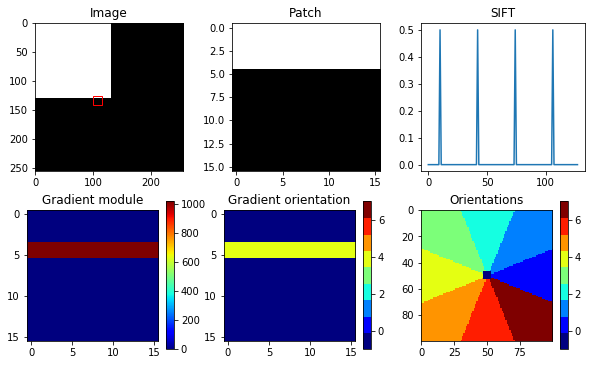

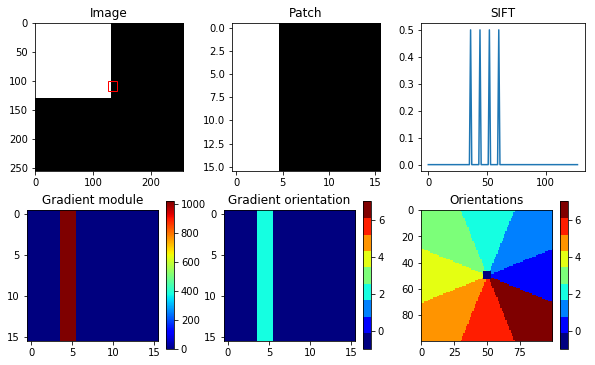

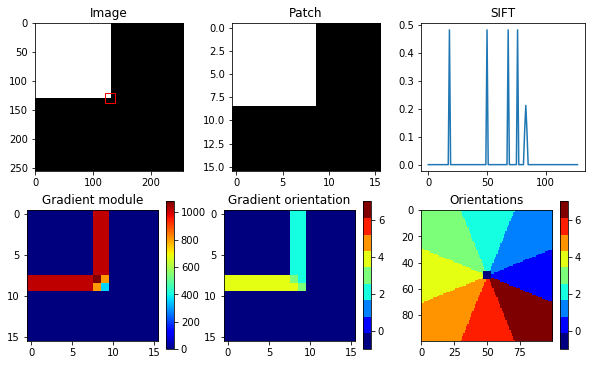

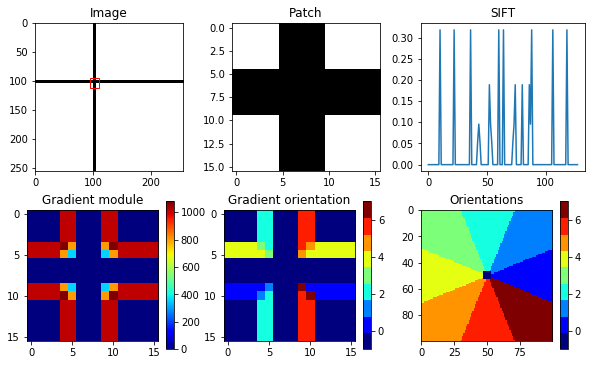

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3181317 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.3181317 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18864812, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.3181317 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.18864

In [4]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I, compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

# Partie 2 : Dictionnaire visuel

In [5]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
from tools import *
from compute_sifts import *
from sklearn.cluster import KMeans

In [6]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')
inames, ilabls, cnames = load_dataset(dir_sc)

In [7]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


In [23]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    print(sift.shape)
    sift = sift[keep]
    print(sift.shape)
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    
    kmeans = KMeans(n_clusters=10, max_iter=1000).fit(sift)
    res = kmeans.cluster_centers_
    res = list(res)
    res.append([0]*dim_sift)
    res = np.array(res)
    return res


In [24]:
# Run the visual dict computation (saved the first time)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict


### Study of the dict
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 2)) # Compute SIFT and regions from 30 random images
#display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

cluster_i = 0
d = np.linalg.norm(sifts - vdict[cluster_i], axis=1)
ind = np.argsort(d)[::-1][:49]

display_images(regions[ind])# Show regions


# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

# Partie 3 : BoW

In [26]:
# Compute BoW for an image

def compute_feats(vdict, image_sifts):
    kmeans = KMeans()
    kmeans.cluster_centers_ = vdict
    
    predicted = [kmeans.predict(sift) for sift in image_sifts]

    pooling = np.zeros(len(vdict))
    for pred in predicted:
        pooling[pred] += 1
    
    #assert(pooling.sum() == len(image_sifts))
    pooling /= np.linalg.norm(pooling)
    print(pooling)
    return pooling

[0.40406881 0.31622777 0.24595493 0.29865956 0.35136418 0.03513642
 0.36893239 0.43920523 0.35136418 0.07027284 0.07027284]


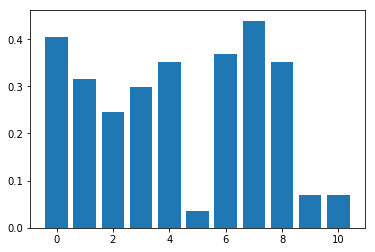

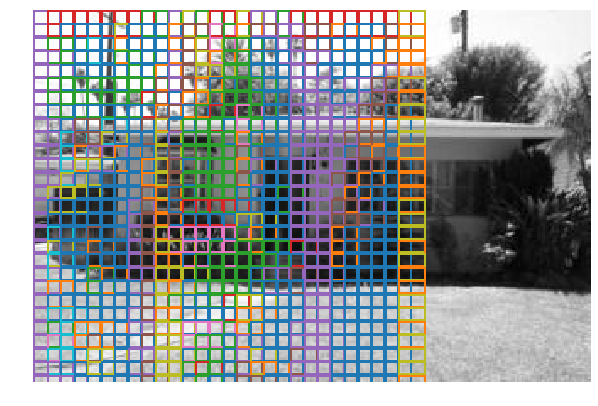

(9, 16, 16)


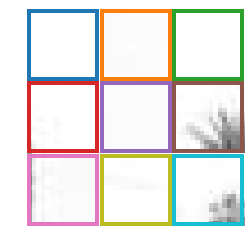

In [27]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)*255
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here